# Gaussian Processes in R

In [1]:
library(rstan)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [6]:
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

In [7]:
alpha_true <- 3
rho_true <- 5.5
sigma_true <- 2

N_total = 501
x_total <- 20 * (0:(N_total - 1)) / (N_total - 1) - 10

simu_data <- list(alpha=alpha_true, 
                  rho=rho_true,
                  sigma=sigma_true,
                  N=N_total, x=x_total)

In [12]:
model <- "
data {
  int<lower=1> N;
  real x[N];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N] f = multi_normal_cholesky_rng(rep_vector(0, N), L_cov);
  vector[N] y;
  for (n in 1:N)
    y[n] = normal_rng(f[n], sigma);
}"

In [15]:
writeLines(readLines("simu.stan"))

data {
  int<lower=1> N;
  real x[N];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N] f = multi_normal_cholesky_rng(rep_vector(0, N), L_cov);
  vector[N] y;
  for (n in 1:N)
    y[n] = normal_rng(f[n], sigma);
}


In [17]:
simu_fit <- stan(file='simu.stan', data=simu_data, iter=1,
            chains=1, seed=494838, algorithm="Fixed_param")


SAMPLING FOR MODEL 'simu' NOW (CHAIN 1).
Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.000269 seconds (Sampling)
               0.000269 seconds (Total)



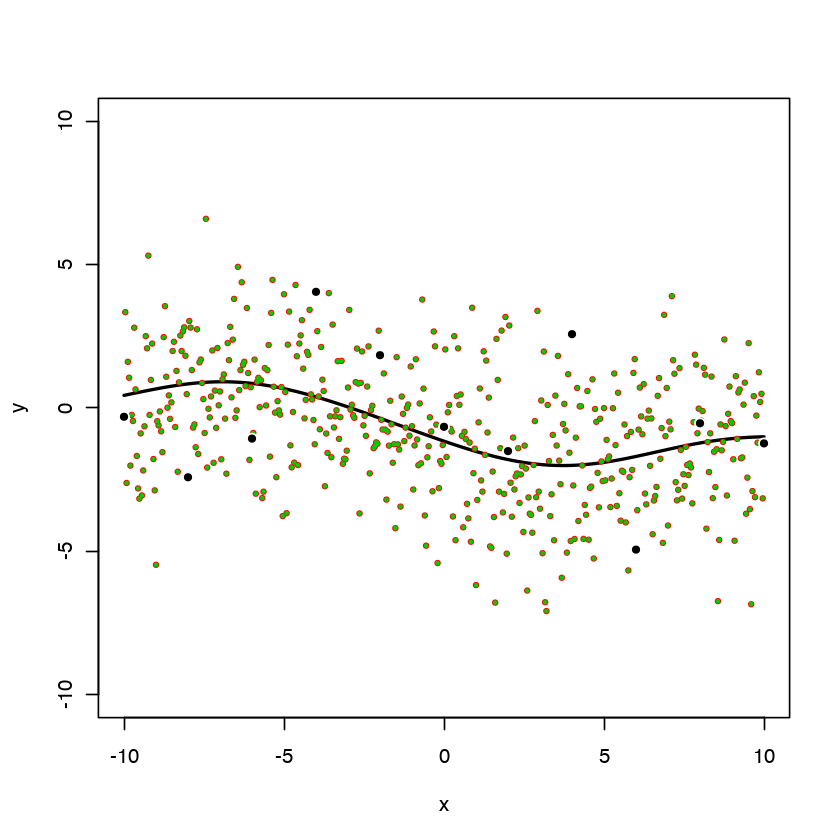

In [20]:
f_total <- extract(simu_fit)$f[1,]
y_total <- extract(simu_fit)$y[1,]

true_realization <- data.frame(f_total, x_total)
names(true_realization) <- c("f_total", "x_total")

observed_idx <- c(50*(0:10)+1)
N = length(observed_idx)
x <- x_total[observed_idx]
y <- y_total[observed_idx]

plot(x_total, f_total, type="l", lwd=2, xlab="x", ylab="y",
     xlim=c(-10, 10), ylim=c(-10, 10))
points(x_total, y_total, col="red", pch=16, cex=0.6)
points(x_total, y_total, col=3, pch=16, cex=0.4)
points(x, y, col="white", pch=16, cex=1.2)
points(x, y, col="black", pch=16, cex=0.8)